In [8]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
import torch
import time
from torch.distributions import Normal, MultivariateNormal, kl_divergence, Distribution, Categorical, constraints
from torch.distributions.utils import _standard_normal, broadcast_all
from normal import GaussianMixture
from torch import Tensor
import scipy.stats as sts

$ \displaystyle KL(f ~|~g) = \int f \log \left( \frac{f}{g} \right) $


$ KL(f=\sum_i \alpha_i f_i ~\|~g=\sum_i \beta_i g_i ) =\sum_k {\alpha_k  \left( KL(f_k~\|~g_k) - \int f_k \log\left( \frac{g}{g_k} \right) +  \int f_k \log\left(\frac{f}{f_k}\right) \right)} $

On  utilise alos comme estimateur : \
$ \sum_k {\alpha_k  \left( KL(f_k~\|~g_k) - \frac{1}{L}\sum_l \log\left( \frac{g (x_{k_l})}{g_k (x_{k_l})} \right) +  \frac{1}{L}\sum_l \log\left(\frac{f (x_{k_l})}{f_k(x_{k_l})}\right) \right)}  $ \
Où $x_{k_l} \overset{i.i.d.}{\thicksim} f_k$ 

In [9]:
class Normal(Normal):

	arg_constraints = {'loc': constraints.real, 'scale': constraints.nonnegative}
	support = constraints.real
	has_rsample = True
	_mean_carrier_measure = 0

	def __init__(
			self,
			loc,
			scale,
			scale_m=None,
			split_sizes=None,
			*args, **kwargs,
	):
		super().__init__(loc, scale, *args, **kwargs)

		self.scale_m = scale_m
		if scale_m is not None:
			self.loc, self.scale_m = broadcast_all(loc, scale_m)

		if split_sizes is None:
			try:
				self.split_sizes = (self.loc.shape[0],)
			except:
				pass
		else:
			assert sum(split_sizes) == self.loc.shape[0]
			self.split_sizes = split_sizes

	@property
	def stddev(self):
		if self.scale_m is None:
			return self.scale
		else:
			return self.variance.pow(0.5)

	@property
	def variance(self):
		if self.scale_m is None:
			return self.scale.pow(2)
		else:
			return self.scale.pow(2) + self.scale_m.pow(2)


	def __mul__(self, other):
		"""
		The Product of two Gaussian PDFs is a Scaled (un-normalized) Gaussian PDF.
		Here we provide only the proper (normalized) PDF.
		"""
		if other == 1:
			return self

		mean, var = multiply_gaussians(self.mean, self.variance, other.mean, other.variance)

		return Normal(loc=mean, scale=var.pow(0.5))

	def __truediv__(self, other):

		if other == 1:
			return self

		mean, var = divide_gaussians(self.mean, self.variance, other.mean, other.variance)

		return Normal(loc=mean, scale=var.pow(0.5))

	def __pow__(self, power, modulo=None):
		assert isinstance(power, int)
		assert power >= 0
		if power == 0:
			return 1
		if power == 1:
			return self
		else:
			p = self
			for i in range(1, power):
				p *= self
			return p

	def kl_divergence(self, other):
		return kl_divergence(Normal(loc=self.loc, scale=self.stddev), other)

	def kl_divergence_rev(self, other):
		return kl_divergence(other, self)

	def kl_divergence_symm(self, other):
		return 0.5 * (self.kl_divergence(other) + self.kl_divergence_rev(other))

	def kl_from_log_uniform(self):
		return KL_log_uniform(mu=self.loc, logvar=self.scale.pow(2).log())

	def plot(self,  *args, **kwargs):
		if len(self.loc.shape) > 1:
			self._plot_n()
		else:
			x = self.sample((1000,)).sort(0)[0]
			p = self.log_prob(x).exp()
			plt.plot(x.detach().numpy(), p.detach().numpy(), *args, **kwargs)

	def _plot_n(self):
		for l, s in zip(self.loc, self.stddev):
			Normal(loc=l, scale=s).plot()

	def pdf(self, x):
		return self.log_prob(x).exp()



In [22]:
class GaussianMixture(Distribution):

	arg_constraints = {}

	def __init__(
			self, 
			weights, 
			locs, 
			scales,
			*args, **kwargs):
		
		super().__init__(locs, scales, *args, **kwargs)
		self.locs = torch.Tensor(locs)
		self.scales = torch.Tensor(scales)
		self.weights = weights  # Probabilités de mélange pour chaque composante
		try :
			self.components = [MultivariateNormal(loc, scale) for loc, scale in zip(self.locs, self.scales)]  # Création de chaque gaussienne
		except :
			self.components = [Normal(loc, scale) for loc, scale in zip(self.locs, self.scales)]
		self.shape = Tensor(locs[0]).shape
		self.num_components = len(locs)

	@property
	def stddev(self):
			return self.variance.pow(0.5)

	@property
	def variance(self):
			return sum(w*scale.pow(2) for w, scale in zip(self.weight, self.scales))
		
	def pdf(self, x):
		s= 0
		for i,f in enumerate(self.components):
			s+= self.weights[i] * f.pdf(x)
		return s
	

	def rsample(self, sample_shape=None):

		# Tirer des indices pour choisir quel composant à échantillonner selon les poids
		component_indices = Categorical(self.weights).sample(sample_shape)
        
        # Initialiser un tenseur vide pour stocker les échantillons
		samples = torch.zeros(*sample_shape, self.locs.shape[1])  # Forme (n_samples, dimension)
        
        # Tirer un échantillon pour chaque composant sélectionné
		for i in range(self.num_components):
			mask = (component_indices == i)  # Mask des indices qui correspondent au composant i
			num_samples = mask.sum().item()  # Nombre d'échantillons à générer pour ce composant
			
			if num_samples > 0:  # Si ce composant est sélectionné
                # Échantillonner les valeurs à partir du composant correspondant
				component_samples = self.components[i].sample((num_samples,))
                
                # Remplacer les échantillons dans le tenseur final
				samples[mask] = component_samples
				
		return samples

	def log_prob(self, value):
		# Calculer la log-probabilité pour chaque composante et sommer avec les poids
		log_probs = torch.stack([component.log_prob(value) + torch.log(weight)
									for component, weight in zip(self.components, self.weights)])

		# Log-sum-exp pour obtenir la log densité de probabilité du mélange
		return torch.logsumexp(log_probs, dim=0, keepdim=True)



faire un notebook propre : juste coder les pdf d'une gaussienne (multidim) et comment tirer un mélange : le tout sans tenseur

In [131]:
def monte_carlo_integral(f, 
                         d=1,
                         q=None, 
                         sampler =None, 
                         N=10_000):
    """
    Estime une intégrale par Monte-Carlo avec importance sampling.
    
    Arguments :
    - f : fonction à intégrer 
    - q : densité de probabilité utilisée pour l'échantillonnage (par défaut : N(0,1))
    - sampler : fonction générant des échantillons selon q (par défaut : N(0,1))
    - N : nombre de points de Monte-Carlo

    Retourne :
    - Approximation de ∫ f(x) dx 
    """
    if sampler is None:
        sampler=lambda n: np.random.normal(0, 1, (n,d))

    if q is None:
        q = lambda x: sts.multivariate_normal(mean=np.zeros(d), cov=np.eye(d)).pdf(x)

    # Tirer N échantillons selon la densité q
    x_samples = sampler(N)
    
    # Calcul des poids d'importance : f(x) / q(x)
    weights = f(x_samples) / q(x_samples)
    
    # Stocker l'évolution de l'intégrale estimée au fur et à mesure
    estimates = np.cumsum(weights) / np.arange(1, N + 1)
    
    return estimates



In [108]:
def gaussian_density(mu, cov):
    return sts.multivariate_normal(mean=mu, cov=cov).pdf

def mixture_density(mus, scales, weights):
    def aux(x):
        s=0
        for i in range(len(mus)):
            s+= weights[i]*gaussian_density(mus[i], scales[i])(x)
        
        return s
    return aux

In [109]:
mixture_density([0,0], [1,1],  [1/2, 1/2])(0)

0.3989422804014327

In [110]:
mixture_density([[0,1], [1,0]], [[1,1],[1,1]],  [1/2, 1/2])([2,0])

0.054798292957369425

Definition des méthodes

In [124]:
def mth_mc_global(f,g, N = 100):
    x_l = f.sample(sample_shape= torch.Size([N]))
    val_per_iter = [0]
    for n in range(1,N+1):
        x = x_l[n-1]
        val_ant = val_per_iter[-1]
        term = f.log_prob(x).exp()/g.log_prob(x).exp()
        val_per_iter.append( (val_ant*(n-1) + term.item() )/n )
    return val_per_iter[1:]

def mth_mc_global_v2(f,g, d=1, N=100):
    def fun(x):
        return f(x)*np.log(f(x)/g(x))
    return monte_carlo_integral(fun, d=d, N=N)
    
def mth_mc_part(f,g, N = 100):
    K_f = len(f.weights)
    kl=0
    for k in range(K_f):
        kl_k = kl_divergence(f.components[k], g.components[k])
        kl+= f.weights[k]*kl_k
    
    val_per_iter = np.ones(N)*kl.item()

    g_i0 = g.components[0].log_prob
    sample_x = g.components[0].sample(sample_shape=torch.Size([N]))
    val_per_iter_int= [0]
    for l in range(1, N+1):
        x = sample_x[l-1]
        trm_l_test = 0
        val_ant = val_per_iter_int[-1]
        for k in range(K_f):
            f_k = f.components[k].log_prob
            trm_l_test += ( f.weights[k] * ((f_k(x).exp())/(g_i0(x).exp()))*(f.log_prob(x) - f_k(x) - g.log_prob(x) + g_i0(x)) ).item()
        val_per_iter_int.append( (val_ant*(l-1) + trm_l_test )/l)
    return val_per_iter + np.array(val_per_iter_int[1:]) 

Génération des deux mixtures de gaussiennes identiques

In [204]:
K = 2
dim = 1
eps_f = .1
eps_g = .3
       
# def f
raw_w_alp = abs(np.random.normal(size = K))
alpha_k = Tensor(raw_w_alp/sum(raw_w_alp))
locs_f = Tensor( np.zeros((K,   dim)) ) 
scales_f = Tensor( np.array([np.eye(dim) + eps_f*np.ones((dim, dim)) for _ in range(K) ]) )

#def g
raw_w_bet = abs(np.random.normal(size = K))
beta_k = Tensor(raw_w_bet/sum(raw_w_bet))
locs_g = Tensor( np.ones((K,   dim)) ) 
# locs_g = Tensor( np.random.rand(K, dim) )
scales_g = Tensor( np.array([np.eye(dim) + eps_g*np.ones((dim, dim)) for _ in range(K) ]) )


f = GaussianMixture(weights=alpha_k,  locs = locs_f,   scales = scales_f)
g = GaussianMixture(weights=beta_k,   locs = locs_g,   scales = scales_g)

Plot des iterations de chaque methode

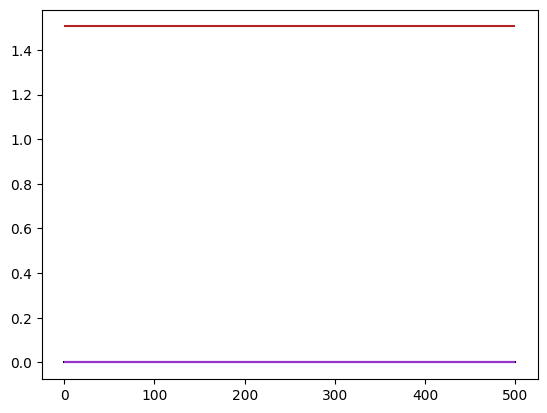

In [191]:
# cas où l'on a deux gaussiennes : on a un point de comparaison analityque

N_max = 500
N_rep = 100
n_min= 1
plt.plot([0, N_max], [0, 0], color='k')

an_val = kl_divergence(f.components[0], g.components[0]).item()

err_glob = np.zeros((N_rep, N_max))
err_part = np.zeros((N_rep, N_max))

for i in range(N_rep):
    mc_part = mth_mc_part(f,g, N = N_max)
    err_part[i] = np.abs(mc_part - an_val)
    
    mc_glob = mth_mc_global_v2(mixture_density(f.locs, f.scales, f.weights), 
                               mixture_density(g.locs, g.scales, g.weights), N = N_max)
    
    err_glob[i] = np.abs(mc_glob - an_val)

plt.plot( np.arange(n_min, N_max), 
         err_part.mean(axis=0)[n_min:], 
         color='darkorchid', 
         label='error partial MC')

plt.plot( np.arange(n_min, N_max), 
         err_glob.mean(axis=0)[n_min:], 
         color='firebrick', 
         label='error global MC')





In [192]:
err_part[:,9].mean(), err_part[:,49].mean(), err_part[:, 99].mean(), err_part[:,499].mean()

(1.5710095446763716e-11,
 1.8142169766477422e-10,
 1.2210114253008442e-10,
 1.652635561733007e-10)

In [193]:
err_glob[:,9].mean(), err_glob[:,49].mean(), err_glob[:,99].mean(), err_glob[:,499].mean()

(1.5046207604612811,
 1.5046207559778881,
 1.5046207598779862,
 1.5046207617910836)

cas avec des 'vrais mélanges'

In [211]:
K = 2
dim = 2
eps_f = .1
eps_g = .3
       
# def f
raw_w_alp = abs(np.random.normal(size = K))
alpha_k = Tensor(raw_w_alp/sum(raw_w_alp))
locs_f = Tensor( np.array([i+ np.zeros(dim) for i in range(K)])) 
scales_f = Tensor( np.array([np.eye(dim) + eps_f*np.ones((dim, dim)) for _ in range(K) ]) )

#def g
raw_w_bet = abs(np.random.normal(size = K))
beta_k = Tensor(raw_w_bet/sum(raw_w_bet))
locs_g = Tensor( np.array([i+ np.ones(dim) for i in range(K)])) 
# locs_g = Tensor( np.random.rand(K, dim) )
scales_g = Tensor( np.array([np.eye(dim) + eps_g*np.ones((dim, dim)) for _ in range(K) ]) )


f = GaussianMixture(weights=alpha_k,  locs = locs_f,   scales = scales_f)
g = GaussianMixture(weights=beta_k,   locs = locs_g,   scales = scales_g)

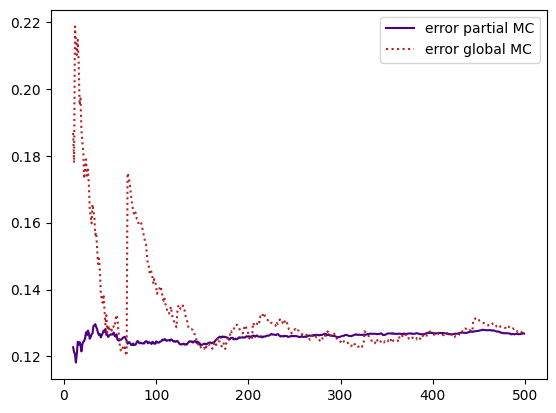

In [212]:
# cas où l'on a vraiment des mélanges : on N'a PAS de point de comparaison analityque

N_max = 500
N_max_aff = 500
N_rep = 50
n_min= 10
n_min_calc_synth = 2*N_max//3


res_mc_glob = np.zeros((N_rep, N_max))
res_mc_part = np.zeros((N_rep, N_max))

err_glob = np.zeros((N_rep, N_max))
err_part = np.zeros((N_rep, N_max))

for i in range(N_rep):
    res_mc_part[i] = mth_mc_part(f,g, N = N_max)
    
    res_mc_glob[i] = mth_mc_global_v2(mixture_density(f.locs, f.scales, f.weights), 
                                      mixture_density(g.locs, g.scales, g.weights),
                                      d=dim,
                                      N = N_max)

val_synth = .5*res_mc_part[:, n_min_calc_synth:].mean() + .5*res_mc_glob[:, n_min_calc_synth:].mean()

for i in range(N_rep):
    err_part[i] = np.abs(res_mc_part[i] - val_synth)
    err_glob[i] = np.abs(res_mc_glob[i] - val_synth)

plt.plot( np.arange(n_min, N_max_aff), 
         err_part.mean(axis=0)[n_min:N_max_aff], 
         color='indigo', 
         label='error partial MC')

plt.plot( np.arange(n_min, N_max_aff), 
         err_glob.mean(axis=0)[n_min:N_max_aff], 
         ':',
         color='firebrick', 
         label='error global MC')

plt.legend()

In [213]:
err_glob[:,9].mean(), err_glob[:, 49].mean(), err_glob[:, 99].mean(), err_glob[:,499].mean()

(0.17693968650837302,
 0.12759477894382665,
 0.14241409749856845,
 0.12751887251670696)

In [214]:
err_part[:,9].mean(), err_part[:, 49].mean(), err_part[:, 99].mean(), err_part[:,499].mean()

(0.12233270637942635,
 0.1262083729648109,
 0.12380114156744872,
 0.126845117935789)

In [216]:
err_glob[:,9].sum(), err_glob[:, 49].sum(), err_glob[:, 99].sum(), err_glob[:,499].sum()

(8.846984325418651, 6.379738947191332, 7.120704874928422, 6.3759436258353475)

In [215]:
err_part[:,9].sum(), err_part[:, 49].sum(), err_part[:, 99].sum(), err_part[:,499].sum()

(6.116635318971317, 6.310418648240546, 6.190057078372436, 6.3422558967894505)